In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import (
    make_scorer, confusion_matrix, roc_curve, auc
)
from sklearn.feature_selection import mutual_info_classif

C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the teams data
teams = pd.read_csv('./cleaned_data/teams.csv')

features = [
    'playoff_progression_score',
    'REB_per_Game',
    'DREB%',
    'OREB%',
    'Net_eFG%',
    'Win%',
    'rank',
]

label = 'next_season_playoff'

# Prepare feature and label data
X = teams[features]
y = teams[label]

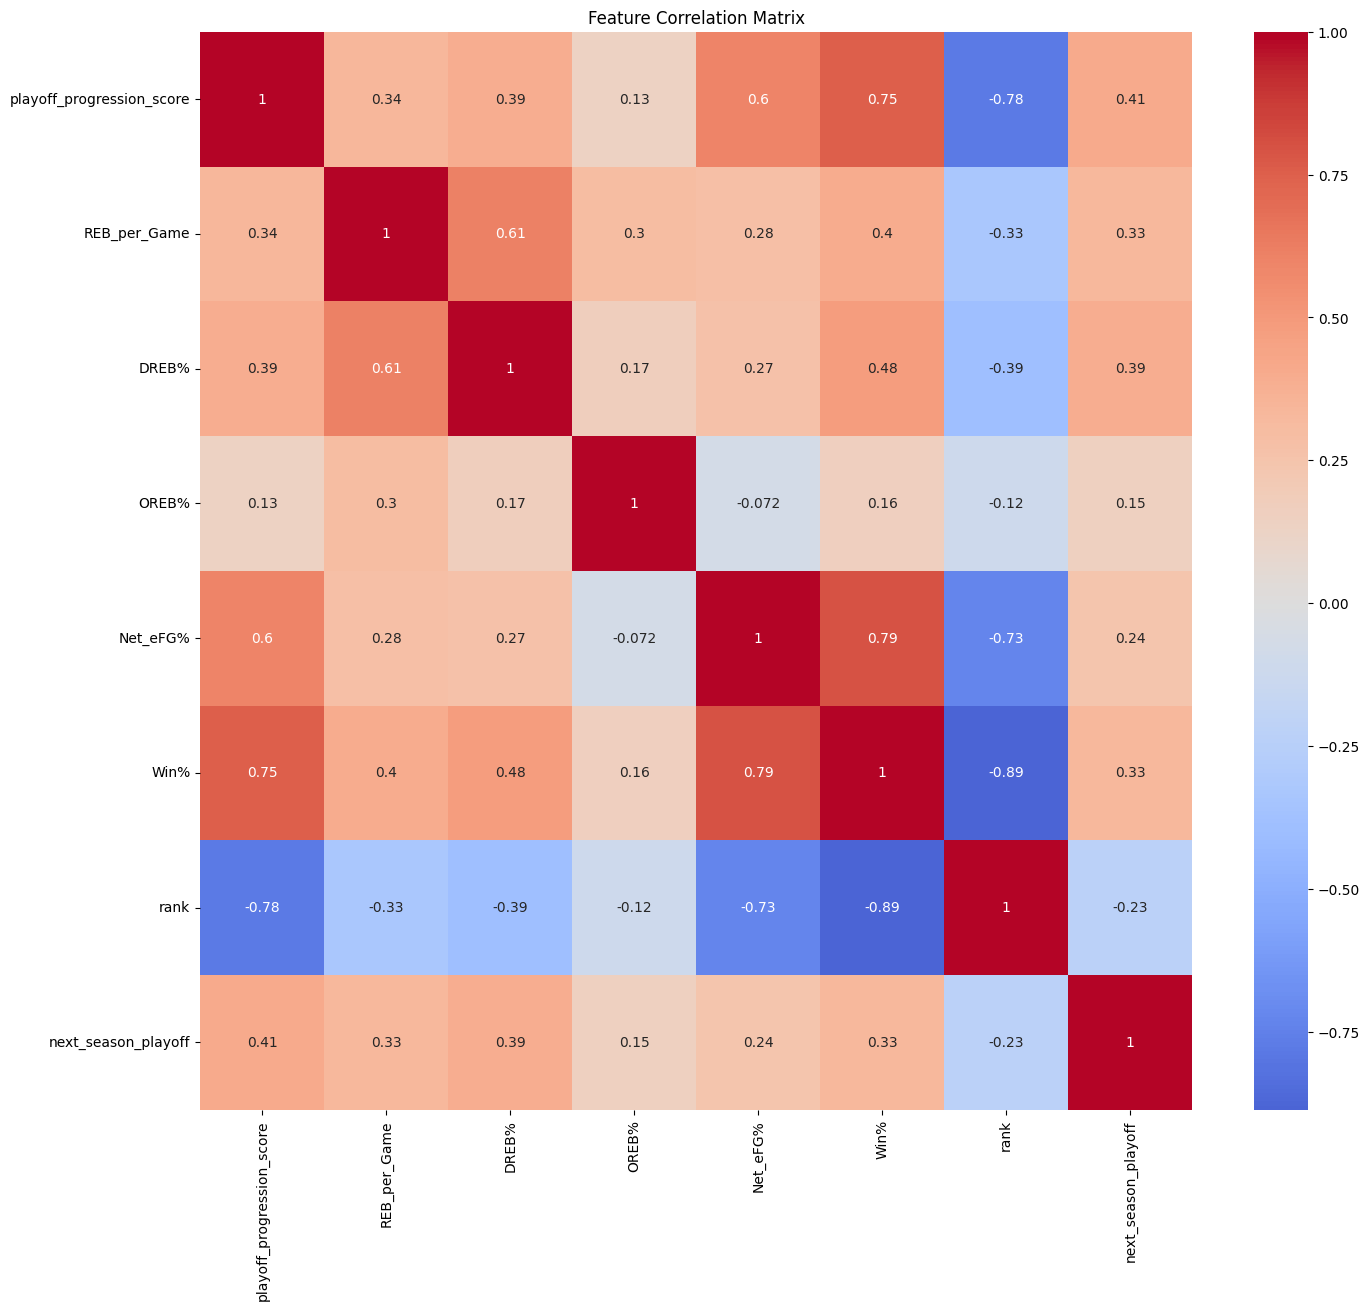

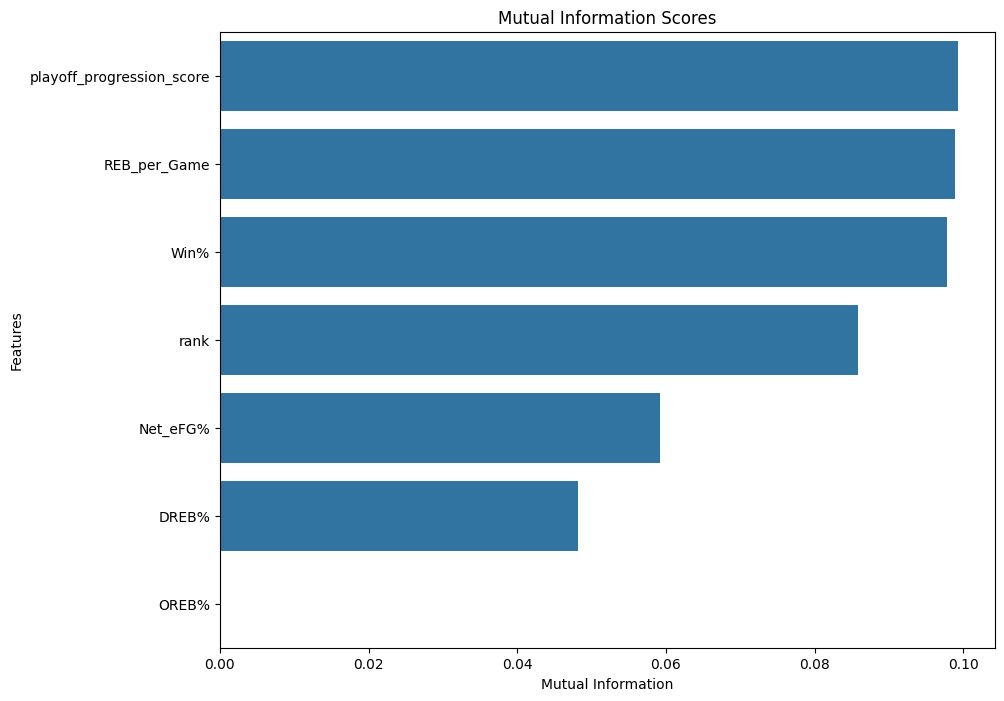

In [3]:
# Calculate and plot the correlation matrix between features and label
correlation_matrix = teams[features + [label]].corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.savefig('./images/feature_correlation.png', dpi=300)
plt.show()

# ============================
# Mutual Information Calculation
# ============================

# Calculate mutual information between each feature and the target
mutual_info = mutual_info_classif(X, y, discrete_features='auto')
mutual_info_series = pd.Series(mutual_info, index=features)

# Sort and plot mutual information scores
mutual_info_series = mutual_info_series.sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=mutual_info_series.values, y=mutual_info_series.index)
plt.title('Mutual Information Scores')
plt.xlabel('Mutual Information')
plt.ylabel('Features')

plt.savefig('./images/mutual_info.png', dpi=300)

plt.show()

In [4]:
# ============================
# Define the XGBoost model with the parameters obtained from the optuna study bellow
# ============================

model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    subsample=0.7233635721775727,
    scale_pos_weight=1,
    reg_lambda=0.379240385531029,
    reg_alpha=0.43215689702580345,
    n_estimators=106,
    min_child_weight=4,
    max_depth=7,
    gamma=2.6572201694041264,
    learning_rate=0.03438884691930227,
    colsample_bytree=0.5621404022241934
)

In [5]:
# Use StratifiedKFold to maintain class distribution in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

In [6]:
'''Use to fine tune the hyper parameters when testing a new set of features
# Define the objective function
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100)
    }
    
    model = XGBClassifier(**param, random_state=42, eval_metric='logloss')
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(model, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    return score.mean()

# Set the random seed in the sampler
sampler = optuna.samplers.TPESampler(seed=42)

# Create a study with the sampler
study = optuna.create_study(direction='maximize', sampler=sampler)

# Optimize the study
study.optimize(objective, n_trials=1000, n_jobs=-1)

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best ROC AUC Score:", study.best_value)
'''

'Use to fine tune the hyper parameters when testing a new set of features\n# Define the objective function\ndef objective(trial):\n    param = {\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.3),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.5, 1.0),\n        \'gamma\': trial.suggest_float(\'gamma\', 0, 5),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0, 1),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0, 1),\n        \'scale_pos_weight\': trial.suggest_int(\'scale_pos_weight\', 1, 100)\n    }\n    \n    model = XGBClassifier(**param, random_state=42, eval_metric=\'logloss\')\n    skf = StratifiedKFold(n_splits=10, s

In [7]:
cv_results = cross_validate(
    model, X, y, cv=skf, scoring=scoring, return_estimator=False
)

# Output the cross-validation results
print("Mean Cross-Validation Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Cross-Validation Precision:", cv_results['test_precision'].mean())
print("Mean Cross-Validation Recall:", cv_results['test_recall'].mean())
print("Mean Cross-Validation F1 Score:", cv_results['test_f1'].mean())
print("Mean Cross-Validation AUC Score:", cv_results['test_roc_auc'].mean())
print("Mean Cross-Validation Specificity:", cv_results['test_specificity'].mean())

Mean Cross-Validation Accuracy: 0.7461904761904762
Mean Cross-Validation Precision: 0.7705158730158731
Mean Cross-Validation Recall: 0.7178571428571429
Mean Cross-Validation F1 Score: 0.7271520146520147
Mean Cross-Validation AUC Score: 0.7387755102040816
Mean Cross-Validation Specificity: 0.7749999999999999


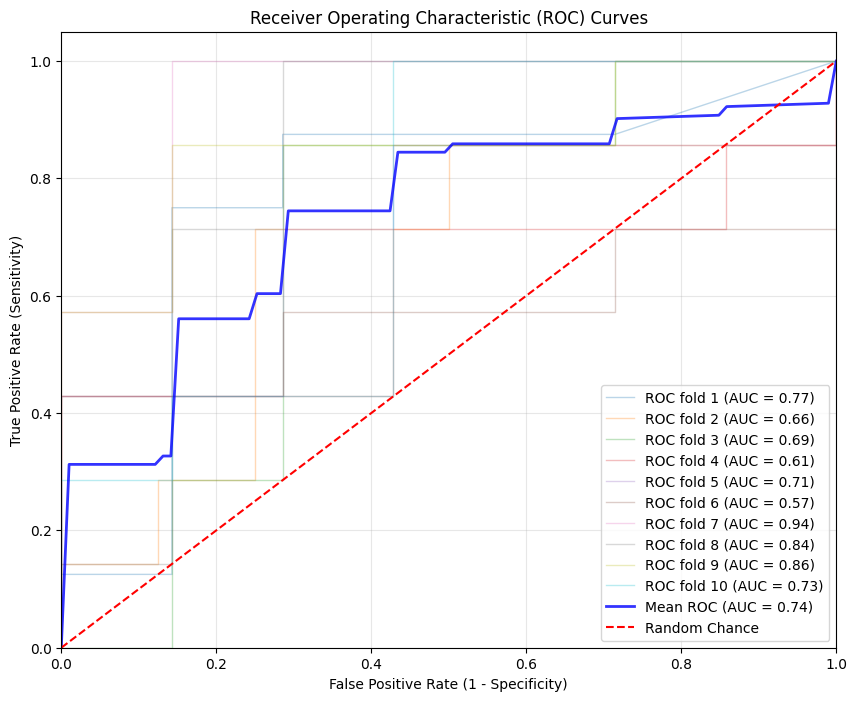

In [8]:
# Visualization of ROC Curves
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get the predicted probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    # Plot the ROC curve for each fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

# Plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(
    mean_fpr, mean_tpr, color='b',
    label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8
)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('./images/ROC_curves.png', dpi=300)
plt.show()

<Figure size 1200x800 with 0 Axes>

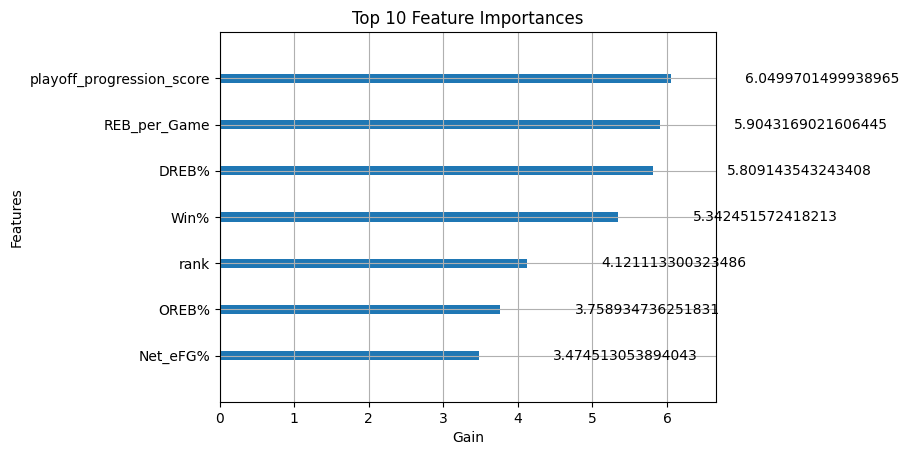

In [9]:
# ============================
# Feature Importance Visualization
# ============================

# Fit the model on the entire dataset
model.fit(X, y)

# Plot feature importance
plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='gain', max_num_features=20, xlabel='Gain')
plt.title('Top 10 Feature Importances')
plt.savefig('./images/feature_importance.png', dpi=300)
plt.show()